# Asymmetry + DEAP (emotion)

In this tutorial, we will be working on the DEAP dataset, a benchmark EEG emotion recognition dataset. 

In this dataset, there is a total of 32 participants, where each participant watches 40 1-minute videos.  Thus <code>s01.dat</code> is holding 40 batches.   For simplicity, we shall only use the first participant, i.e., <code>s01.dat</code>.   

You can download the dataset by googling and ask permission from the owner by filling a form.

Looking in each dat file (e.g., s01), it contains the data and label
- Data ----- 40 x 40 x 8064 [	video/batches x channel x samples ]
- Label  ---- 40 x 4 

Out of 40 channels, 32 channels were of EEG, and the rest of 8 of them from other sensors such as EOG (see the section 6.1 of the original paper).  We shall only extract the first 32 channels.   For the 8064, since the data is downsampled to 128Hz, thus one second contains around 128 samples, thus in one minute which is 60 seconds, it will be roughly 7680 samples.  The paper did not really talk a lot but it is likely there is  another 1.5 seconds before and after which total to 8064 samples (128 Hz * 63 seconds).

The four labels correspond to valence, arousal, liking, and dominance, in this order.  We will only use valence and arousal, thus index 0 and 1 of the labels will be extracted.

For more information, see https://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html

In [1]:
import pickle
import os

import mne
from mne import create_info
from mne.io import RawArray

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
np.set_printoptions(precision=4)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# torch.cuda.get_device_name(0)

## 1. Loading the dataset

Let's first create a simple dataset loader.   The code is explained using comments and is quite self-explanatory.

In [5]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, path, stim):
        _, _, filenames = next(os.walk(path))
        filenames = sorted(filenames)
        all_data = []
        all_label = []
        for dat in filenames:
            temp = pickle.load(open(os.path.join(path,dat), 'rb'), encoding='latin1')
            all_data.append(temp['data'])
            
            if stim == "Valence":
                all_label.append(temp['labels'][:,:1])   #the first index is valence
            elif stim == "Arousal":
                all_label.append(temp['labels'][:,1:2]) # Arousal  #the second index is arousal
                
        self.data = np.vstack(all_data)[:, :32, ]   #shape: (40, 32, 8064) ==> (samples, channels, samples)
        self.label = np.vstack(all_label) #(40, )  ==> 1280 samples, each with a unique label (depend on the param "stim")
        
        del temp, all_data, all_label

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        single_data  = self.data[idx]
        single_label = (self.label[idx] > 5).astype(float)   #convert the scale to either 0 or 1 (to classification problem)
        
        batch = {
            'data': torch.Tensor(single_data),
            'label': torch.Tensor(single_label)
        }
        
        return batch

Let's try load the dataset.

In [6]:
path = "data/deap"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset

In [7]:
dataset_valence = Dataset(path, "Valence")
dataset_arousal = Dataset(path, "Arousal")

We can try look at one sample using the index.  This is automatically mapped to the <code>__getitem__</code> function in the <code>Dataset</code> class.

In [8]:
dataset_valence[0]

{'data': tensor([[ 0.9482,  1.6533,  3.0137,  ..., -2.8265, -4.4772, -3.6769],
         [ 0.1247,  1.3901,  1.8351,  ..., -2.9870, -6.2878, -4.4743],
         [-2.2165,  2.2920,  2.7464,  ..., -2.6371, -7.4065, -6.7559],
         ...,
         [-3.5572, -1.2603, -3.0996,  ...,  6.6889,  6.9123,  5.6690],
         [-1.2373, -0.9414,  1.0280,  ...,  2.6402,  6.5746,  7.2085],
         [ 0.3723,  2.0762,  4.4652,  ...,  2.2396,  3.1826,  4.7081]]),
 'label': tensor([1.])}

In [9]:
print("Shape of data: ", dataset_valence[0]['data'].shape)  #32 channels of data, 8064 samples in 1 minute
print("Shape of label: ", dataset_valence[0]['label'].shape) #just 1 single label; 0 or 1

Shape of data:  torch.Size([32, 8064])
Shape of label:  torch.Size([1])


Let's try to look at our data and label distribution.

In [10]:
data = dataset_valence[:]['data']
label = dataset_valence[:]['label']

In [11]:
#so we got 40 trials (40 videos, each with 32 channels of data, each video contains 8064 EEG samples)
data.shape  

torch.Size([40, 32, 8064])

In [12]:
#so we got 40 labels, i.e., one label per video
label.shape  

torch.Size([40, 1])

Let's count how many 0 and 1 in the valence dataset, to see if there is some imbalance.

In [13]:
cond_1 = label == 1
cond_0 = label == 0

print("Labels 1 in valence dataset: ", len(label[cond_1]))
print("Labels 0 in valence dataset: ", len(label[cond_0]))

Labels 1 in valence dataset:  19
Labels 0 in valence dataset:  21


Let's also count in the arousal dataset, to see if there is some imbalance.

In [14]:
cond_1 = label == 1
cond_0 = label == 0

print("Labels 1 in arousal dataset: ", len(label[cond_1]))
print("Labels 0 in arousal dataset: ", len(label[cond_0]))

Labels 1 in arousal dataset:  19
Labels 0 in arousal dataset:  21


## 2. Artifact Removal

Note that since the data is already preprocessed by the authors, we don't have to do anything more, but it's very natural for us to do preprocessing, e.g., min-max normalization, notch filters, band pass filters, etc.

Base on the information given in the DEAP website, the preprocessed data has done the following;

1. The data was downsampled to 128Hz.
2. EOG artefacts were removed as in [1].
3. A bandpass frequency filter from 4.0-45.0Hz was applied.
4. The data was averaged to the common reference.
5. The EEG channels were reordered so that they all follow the Geneva order as above.
6. The data was segmented into 60 second trials and a 3 second pre-trial baseline removed.
7. The trials were reordered from presentation order to video (Experiment_id) order.

## 3. Epoching

Given that DEAP dataset already provides their data in epochs, we can simply put these epochs as mne epochs object by using `mne.EpochsArray`

In [15]:
#meta data
ch_names = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
ch_types = ['eeg'] * len(ch_names)
sfreq = 128 #Hz
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

#create epochs
epochs = mne.EpochsArray(dataset_valence[:]['data'],info)

#set headset mapping
epochs.set_montage('standard_1020')
print('----')
# You can access the original data using <>._data 
print(f"{epochs._data.shape=}")
print('----')
epochs

Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
----
epochs._data.shape=(40, 32, 8064)
----


Number of events,40
Events,1: 40
Time range,0.000 – 62.992 sec
Baseline,off


Here is some short summary regarding mne data structures:

https://mne.tools/stable/most_used_classes.html

1. `MNE.io.Raw`
  - The `MNE.io.Raw` is you entire session. In this class, you can perform a preprocess for the entire session like `filter`
2. `MNE.Epochs`
  - The Epochs is an idea for segment the entire session to smaller windows. You can epoching you session in any how you like. The most common epoching is to follow the `marker/event` channel
3. `MNE.Evoked`
  - Evoked is a data that you obtain from each epoch. You can think of the Epochs is an Array of Evoked.
4. `MNE.Spectrum`
  - for all three objects above, once you called `compute_psd()`, it became a MNE Spectrum instance, in which you can retrieve power of different frequencies.

## 4. EDA - Spectral Analysis

Here we  focus on feature engineering using spectral analysis.  Spectral analysis here refers to the analysis of theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz), and gamma (30 - 64 Hz).   

Spectral analysis is a very basic and must-do analysis for emotions/cognitions/resting state since it is a common knowledge with abundant evidence that our emotion/cognition change how our brain signals oscillate.  For example, when we are calm, alpha is relatively high, likewise, when we are attentive, beta is relatively high and alpha becomes relatively lower.

MNE has functions to calulate PSD. There are multiple methods to get PSD from a signal (and other Voltage-to-Frequency domain convert technique).

A welch method is widely used.


In [16]:
epoch = epochs.__getitem__(0) #first epoch
spectrum = epoch.compute_psd(method="welch", n_fft=128) #get Spectrum object from epochs
psds, freqs = spectrum.get_data(return_freqs=True)
print(psds.shape, freqs.shape)

Effective window size : 1.000 (s)
(1, 32, 65) (65,)


`psd_welch` returns you two objects, PSDs and FREQs.

The shape of PSDs is (n_epochs,n_channels,n_freqs) and FREQs is (n_freqs)

As you can see, the range of frequency returned from the function is [0-64] because of nyquist theory.

The basic is you can only obtain frequncy range up to sampling_rate/2. In this data, the sampling rate/freq is 128Hz, therefor the maximun frequncy is 128/2 = 64 Hz.

This is specified using the `n_fft` parameter as 128.

Now let's retrieve the power for all 40 epochs, by putting epochs instead of epoch.  In addition, we shall apply a log to the psds, which is a common way to enhance the visibility of the spectrum.

In [17]:
spectrum = epochs.compute_psd(method="welch", n_fft=128, )  #get Spectrum object from epochs
psds, freqs = spectrum.get_data(return_freqs=True)
psds = 10 * np.log10(psds)
print(psds.shape, freqs.shape)

Effective window size : 1.000 (s)
(40, 32, 65) (65,)


Let's try to plot different bands, and see their difference

In [18]:
#1. first we take the mean of all channels
psds = psds.mean(axis=1)
psds.shape #(40, 65)

(40, 65)

Next we gonna the `(_,65)` to `(_,5)`, i.e., delta (0-4), theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz), and gamma (30 - 64 Hz)

**Note that the range of delta,theta,... is different from paper to paper*

In [19]:
delta = psds[:, :5]
theta = psds[:, 4:9]
alpha = psds[:, 8:13]
beta  = psds[:, 12:31]
gamma = psds[:, 30:]

delta.shape, theta.shape, alpha.shape, beta.shape, gamma.shape

((40, 5), (40, 5), (40, 5), (40, 19), (40, 35))

Then we can just mean all the power 

In [20]:
delta = delta.mean(axis=1).reshape(-1, 1)
theta = theta.mean(axis=1).reshape(-1, 1)
alpha = alpha.mean(axis=1).reshape(-1, 1)
beta  = beta.mean(axis=1).reshape(-1, 1)
gamma = gamma.mean(axis=1).reshape(-1, 1)

delta.shape, theta.shape, alpha.shape, beta.shape, gamma.shape

((40, 1), (40, 1), (40, 1), (40, 1), (40, 1))

For plotting the bar graph, let's stack them together

In [21]:
_temp = [delta, theta, alpha, beta, gamma]
all_bands = np.hstack(_temp)
all_bands.shape

(40, 5)

Now let's plot it!

In [22]:
#first turn it into dataframe
df = pd.DataFrame(all_bands, columns = ['delta','theta','alpha', 'beta', 'gamma'])
df.head()

,delta,theta,alpha,beta,gamma
0,-19.416558,-0.385428,-0.287428,-6.156266,-31.307289
1,-18.574723,0.795895,0.153971,-6.109330,-30.781067
2,-19.416556,0.929937,0.823071,-5.387953,-30.326138
3,-19.438499,1.135004,0.137797,-6.246238,-30.726357
4,-21.480252,-2.195351,-0.587706,-6.380772,-31.869710


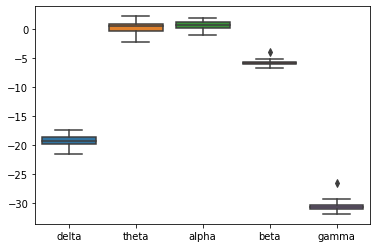

In [23]:
sns.boxplot(data = df)
plt.show()

Here, it's quite difficult to infer anything, so let's try to see whether there is any differences in these bands across the two valence conditions

In [24]:
low_valence_cond  = (label==0).reshape(-1) #reshape to (40, ) instead of (40, 1)
high_valence_cond = (label==1).reshape(-1) #reshape to (40, ) instead of (40, 1)
low_valence  = all_bands[low_valence_cond]
high_valence = all_bands[high_valence_cond]
low_valence.shape, high_valence.shape

((21, 5), (19, 5))

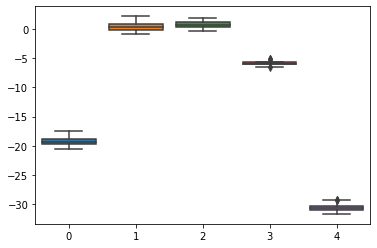

In [25]:
sns.boxplot(data = low_valence)
plt.show()

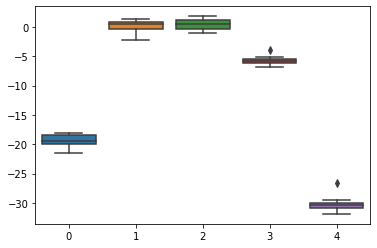

In [26]:
sns.boxplot(data = high_valence)
plt.show()

Nothing!  Almost invisible difference.  From this EDA, we can kinda conclude that it is quite pointless to try machine learning here, since we cannot see any difference

## 5. EDA: Asymmetry

Asymmetry analysis here refers to the analysis of imbalance between left and right symmetrical location.  Asymmetry analysis is another very basic and must-do analysis for emotions/cognitions/resting state.

Here is the channels and their index.

- Channels: 32
  1.	Fp1	
  2.	AF3
  3.	F3
  4.	F7
  5.	FC5
  6.	FC1
  7.	C3
  8.	T7
  9.	CP5
  10.	CP1
  11.	P3
  12.	P7
  13.	PO3
  14.	O1
  15.	Oz
  16.	Pz
  17.	Fp2
  18.	AF4
  19.	Fz
  20.	F4
  21.	F8
  22.	FC6
  23.	FC2
  24.	Cz
  25.	C4
  26.	T8
  27.	CP6
  28.	CP2
  29.	P4
  30.	P8
  31.	PO4
  32.	O2

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6e/International_10-20_system_for_EEG-MCN.svg" width="400">

We will seperate the channels into left-ones and right-ones

Based on 10-20 system, the followed number if odd, is on the left (if even, on the right). `z` is middle.

Based on this paper, [EEG-Based Emotion Recognition Using Logistic Regression with Gaussian Kernel and Laplacian Prior and Investigation of Critical Frequency Bands](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwj7kei-1Mr2AhVTzDgGHdH_D3oQFnoECAkQAQ&url=https%3A%2F%2Fwww.mdpi.com%2F2076-3417%2F10%2F5%2F1619%2Fpdf&usg=AOvVaw3nwBT1NPFALmqKKm4rbIuE), there are 14 pairs of left-right of asymmetry we can engineer.

1. Fp1-Fp2
2. F7-F8
3. F3-F4
4. T7-T8
5. P7-P8
6. C3-C4
7. P3-P4
8. O1-O2
9. AF3-AF4
10. FC5-FC6
11. FC1-FC2
12. CP5-CP6
13. CP1-CP2
14. PO3-PO4

And there are two relation we can create. Differential Asymmetry (DASM) and Rational Asymmetry (RASM)

Another 11 pairs of frontal-posterior is as follow

1. FC5-CP5
2. FC1-CP1
3. FC2-CP2
4. FC6-CP6
5. F7-P7
6. F3-P3
7. Fz-Pz
8. F4-P4
9. F8-P8
10. Fp1-O1
11. Fp2-O2

The paper uses differential caudality (DCAU)

$$ DASM = DE(X_{left}) - DE(X_{right}) $$
$$ RASM = \frac{DE(X_{left})}{DE(X_{right})} $$
$$ DCAU = DE(X_{frontal}) - DE(X_{posterior}) $$

$ DE() $ is a function that convert PSD to log-PSD which we already did.

In [27]:
channels = ['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
left_channels = ['Fp1','F7','F3','T7','P7','C3','P3','O1','AF3','FC5','FC1','CP5','CP1','PO3']
right_channels = ['Fp2','F8','F4','T8','P8','C4','P4','O2','AF4','FC6','FC2','CP6','CP2','PO4']
left_channel_indexes = [ channels.index(ch) for ch in left_channels ]
right_channel_indexes = [ channels.index(ch) for ch in right_channels ]

print(f"{left_channel_indexes=}")
print(f"{right_channel_indexes=}")

frontal_channels = ['FC5','FC1','FC2','FC6','F7','F3','Fz','F4','F8','Fp1','Fp2']
posterior_channels = ['CP5','CP1','CP2','CP6','P7','P3','Pz','P4','P8','O1','O2']

frontal_channel_indexes = [ channels.index(ch) for ch in frontal_channels ]
posterior_channel_indexes = [ channels.index(ch) for ch in posterior_channels ]

print(f"{frontal_channel_indexes=}")
print(f"{posterior_channel_indexes=}")

left_channel_indexes=[0, 3, 2, 7, 11, 6, 10, 13, 1, 4, 5, 8, 9, 12]
right_channel_indexes=[16, 20, 19, 25, 29, 24, 28, 31, 17, 21, 22, 26, 27, 30]
frontal_channel_indexes=[4, 5, 22, 21, 3, 2, 18, 19, 20, 0, 16]
posterior_channel_indexes=[8, 9, 27, 26, 11, 10, 15, 28, 29, 13, 31]


Let's get PSD. I will use `MNE_feature` since it handles epochs-like data for me and I don't need to analyze the data (remember, the data is already preprocessed)

The idea is as follow;

1. I will slowly calculate PSD of each frequncy band.
2. For each band, I will calculate DASM, RASM, and DCAU

In [28]:
from mne_features.feature_extraction import FeatureExtractor

# bands = dict({
#     "delta": (0,4), 
#     "theta": (4,8),
#     "alpha": (8,12),
#      "beta": (12,30),
#     "gamma": (30,64)
# })

#for simplicity, we gonna just try alpha asymmetry
bands = dict({
    "alpha": (8,12),
})

PSDs = []
DASMs = []
RASMs = []
DCAUs = []
for band_name,band_range in bands.items():
    params = dict({
        'pow_freq_bands__log':True,
        'pow_freq_bands__normalize':False,
        'pow_freq_bands__freq_bands':band_range
    })
    fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'],params=params,n_jobs=8, memory="cache/")
    PSD = fe.fit_transform(X=data)
    #      (40 samples, 32 channels)
    # print("1", PSD.shape)

    PSD_left = PSD[:, left_channel_indexes].copy()
    PSD_right = PSD[:, right_channel_indexes].copy()
    PSD_frontal = PSD[:, frontal_channel_indexes].copy()
    PSD_posterior = PSD[:, posterior_channel_indexes].copy()
    #       (40, 14)     (40, 14)      (40, 11)        (40, 11)
    # print("2", PSD_left.shape, PSD_right.shape, PSD_frontal.shape, PSD_posterior.shape)
    DASM = PSD_left - PSD_right
    #      (40, 14)
    # print("3", DASM.shape)
    RASM = PSD_left / PSD_right
    #      (40, 14)
    # print("4", RASM.shape)
    DCAU = PSD_frontal - PSD_posterior
    #      (40, 11)
    # print("5", DCAU.shape)

    # Will be use later for comparison
    PSDs.append(PSD)
    DASMs.append(DASM)
    RASMs.append(RASM)
    DCAUs.append(DCAU)

PSDs  = np.hstack(PSDs)
DASMs = np.hstack(DASMs)
RASMs = np.hstack(RASMs)
DCAUs = np.hstack(DCAUs)

#     (40, 32) (40, 14) (40, 14) (40, 11)
print(PSDs.shape, DASMs.shape, RASMs.shape, DCAUs.shape)

________________________________________________________________________________
[Memory] Calling mne_features.feature_extraction.extract_features...
extract_features(tensor([[[  0.9482,   1.6533,   3.0137,  ...,  -2.8265,  -4.4772,  -3.6769],
         [  0.1247,   1.3901,   1.8351,  ...,  -2.9870,  -6.2878,  -4.4743],
         [ -2.2165,   2.2920,   2.7464,  ...,  -2.6371,  -7.4065,  -6.7559],
         ...,
         [ -3.5572,  -1.2603,  -3.0996,  ...,   6.6889,   6.9123,   5.6690],
         [ -1.2373,  -0.9414,   1.0280,  ...,   2.6402,   6.5746,   7.2085],
         [  0.3723,   2.0762,   4.4652,  ...,   2.2396,   3.1826,   4.7081]],

        [[ 10.2602,  12.7954,  10.4262,  ...,   6.0222,   7.5391,   9.3522],
         [  9.4919,  12.5898,  10.5740,  ...,   6.0340,   9.0687,   8.7402],
         [  7.1287,  12.2065,   9.4965,  ...,   6.1797,   6.9337,   ..., 
128, ['pow_freq_bands'], funcs_params={ 'pow_freq_bands__freq_bands': (8, 12),
  'pow_freq_bands__log': True,
  'pow_freq_bands

We can try to first look at DASM

In [29]:
low_valence  = DASM[low_valence_cond]
high_valence = DASM[high_valence_cond]
low_valence.shape, high_valence.shape

((21, 14), (19, 14))

In [30]:
dcau_channels = ['FC5-CP5','FC2-CP2','FC6-CP6','F7-P7','F3-P3','Fz-Pz','F4-P4',
                 'F8-P8','FC1-CP1','Fp1-O1','Fp2-O2']
dasm_channels = ['Fp1-Fp2', 'F7-F8','F3-F4', 'T7-T8','P7-P8','C3-C4','P3-P4',
                 'O1-O2','AF3-AF4','FC5-FC6','FC1-FC2','CP5-CP6','CP1-CP2','PO3-PO4']

low_valence_df = pd.DataFrame(low_valence, columns = dasm_channels)
low_valence_df['valence'] = 'low'

high_valence_df = pd.DataFrame(high_valence, columns = dasm_channels)
high_valence_df['valence'] = 'high'

df_concat = pd.concat([low_valence_df, high_valence_df], axis=0)

df_concat.shape

(40, 15)

In [31]:
df_concat.head()

,Fp1-Fp2,F7-F8,F3-F4,T7-T8,P7-P8,C3-C4,P3-P4,O1-O2,AF3-AF4,FC5-FC6,FC1-FC2,CP5-CP6,CP1-CP2,PO3-PO4,valence
0,-0.062019,0.038666,-0.060196,0.102928,0.268888,-0.083480,0.001628,-0.068236,-0.007693,-0.089520,-0.232939,0.133538,-0.053838,0.028254,low
1,-0.110874,0.140154,-0.129525,0.126145,0.275887,-0.105084,0.018208,0.023864,-0.060906,-0.075915,-0.233354,0.189782,-0.000545,0.078809,low
2,-0.050165,0.171666,-0.013033,0.167244,0.169724,-0.093671,0.083920,-0.025555,0.060851,0.029082,-0.254686,0.235639,0.081134,0.158544,low
3,-0.085922,0.056472,-0.075295,0.101701,0.259893,0.000286,0.186839,0.009887,-0.048551,-0.080910,-0.139279,0.273722,0.175995,0.185218,low
4,-0.051658,0.055029,-0.039149,0.037520,0.281425,-0.012369,0.091716,0.034232,0.040922,-0.069554,-0.221318,0.194974,0.086463,0.224313,low


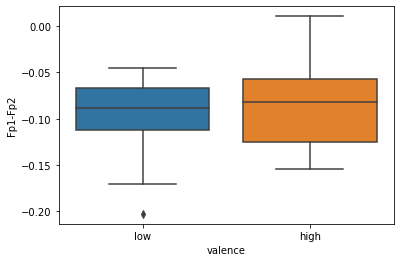

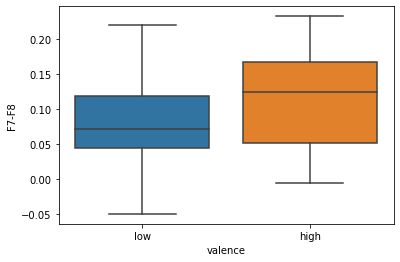

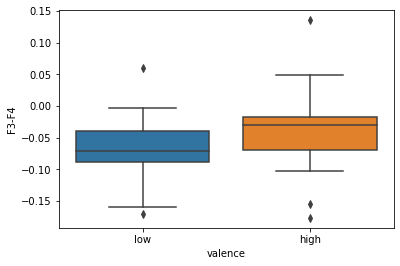

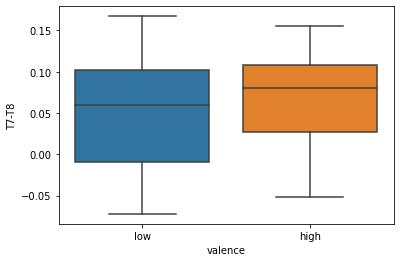

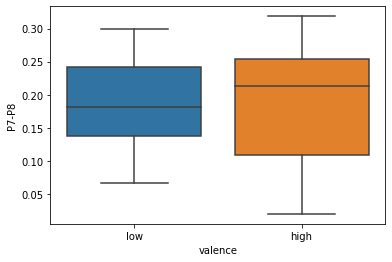

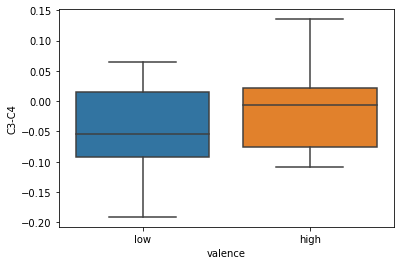

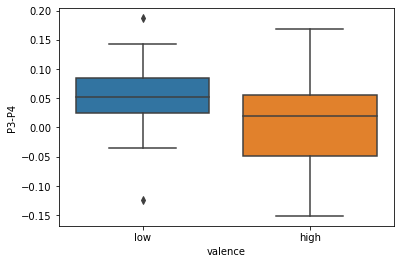

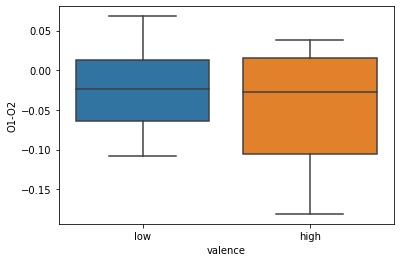

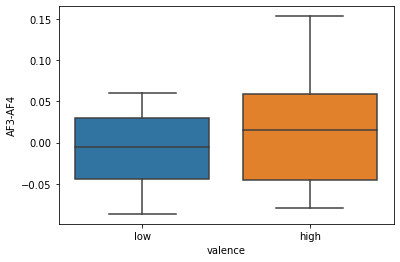

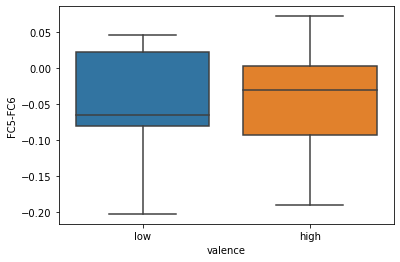

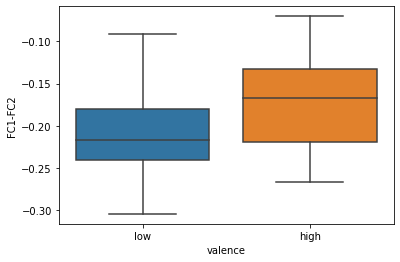

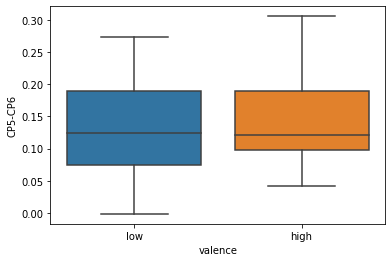

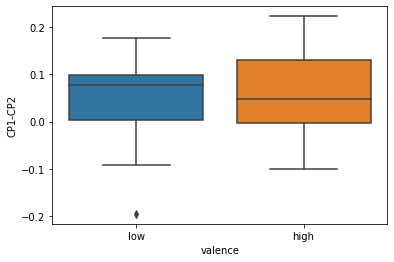

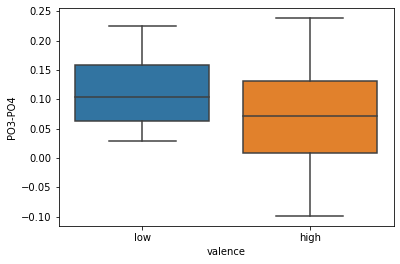

In [32]:
for col in dasm_channels:
    sns.boxplot(data = df_concat, x = 'valence', y = col)
    plt.show()  

Nice!  after scanning, we can see some very observable difference, especially in the frontal nodes.  This proves that asymmetry is kinda useful to understand emotion!   What you can do next is probably trying other asymmetry features, as well as to input strong features into some machine learning algorithm.  You can even try deep learning algorithm!